### Import Library dan Dataset

In [1]:
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

I0000 00:00:1767770179.068631   21019 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1767770179.114642   21019 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1767770180.097567   21019 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
LOCAL_DIR = "../local-indobert-tf"
EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 128

In [5]:
# GPU memory growth (safe for tf-nightly)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Warning: set_memory_growth failed:", e)

# Mixed precision (optional, often supported in tf-nightly)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision unavailable or failed:", e)

# helper to free memory between trials/folds


def free_mem():
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass
    gc.collect()


print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(gpus))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070, compute capability 12.0
Mixed precision enabled: <Policy "mixed_float16">
TensorFlow version: 2.21.0-dev20251013
Num GPUs: 1


W0000 00:00:1767770184.692219   21019 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [6]:
df = pd.read_csv('../data/data_cleaned.csv')
df.head()

,Tweet,Label
0,saya takut kehilangan hal kecil,Takut
1,tidak ada cahaya buat dituju,Sedih
2,rasanya like semuanya sinkron,Gembira
3,yaallah mika angkasa saya kaget saya kira cuma...,Takut
4,saya cemas sejak tadi pagi,Takut


### Persiapan Dataset

In [7]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)

print(f"Total samples: {len(df)}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Total samples: 10075
Number of labels: 5
Label mapping: {'Cinta': np.int64(0), 'Gembira': np.int64(1), 'Marah': np.int64(2), 'Sedih': np.int64(3), 'Takut': np.int64(4)}


In [19]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.30,  # 30% = 3000 samples untuk val + test
    stratify=df["LabelEncoded"],
    random_state=SEED
)

# Split temp menjadi val dan test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, 
    temp_labels,
    test_size=0.50,  # 15% dari total = 1500 samples untuk test
    stratify=temp_labels,
    random_state=SEED
)

print(f"Train: {len(train_texts):,} samples")
print(f"Val: {len(val_texts):,} samples")
print(f"Test: {len(test_texts):,} samples (UNTOUCHED)")

Train: 7,052 samples
Val: 1,511 samples
Test: 1,512 samples (UNTOUCHED)


### Tokenisasi

In [20]:
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)

def tokenize_texts(texts, max_len=MAX_LEN):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

In [21]:
# Batching dataset
def create_tf_dataset(encodings, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_encodings, val_labels, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE, shuffle=False)

### FIne Tuning

In [11]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [12]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=LR)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=metrics
)

In [13]:
# Training
print("Starting final training")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)


Starting final training
Epoch 1/3


E0000 00:00:1766757577.098436  101597 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1766757580.011561  101720 service.cc:158] XLA service 0x790a5802ef90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766757580.011600  101720 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1766757580.021609  101726 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766757580.038901  101726 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1766757580.110440  101726 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


441/441 [==============================] - 113s 192ms/step - loss: 0.5090 - accuracy: 0.8291 - val_loss: 0.3961 - val_accuracy: 0.8676
Epoch 2/3
441/441 [==============================] - 76s 173ms/step - loss: 0.2286 - accuracy: 0.9250 - val_loss: 0.3928 - val_accuracy: 0.8676
Epoch 3/3
441/441 [==============================] - 75s 170ms/step - loss: 0.1409 - accuracy: 0.9521 - val_loss: 0.4214 - val_accuracy: 0.8848


### Evaluasi

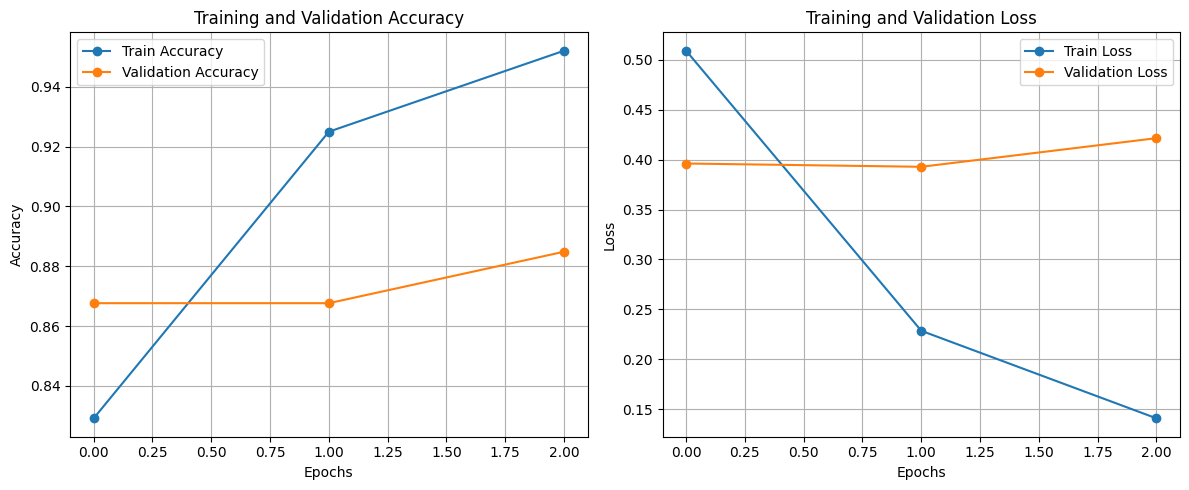

In [14]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




FINAL RESULTS
Test Loss: 0.3960
Test Accuracy: 0.8876


In [16]:
# Predictions dan detailed report
pred_logits = model.predict(test_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)

print("\nCLASSIFICATION REPORT:")
print(classification_report(test_labels, pred_labels,
                            target_names=label_names, digits=4))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Cinta     0.8309    0.9040    0.8659       250
     Gembira     0.9052    0.8726    0.8886       361
       Marah     0.8961    0.8990    0.8976       307
       Sedih     0.8904    0.8638    0.8769       301
       Takut     0.9075    0.9044    0.9060       293

    accuracy                         0.8876      1512
   macro avg     0.8860    0.8888    0.8870      1512
weighted avg     0.8886    0.8876    0.8877      1512



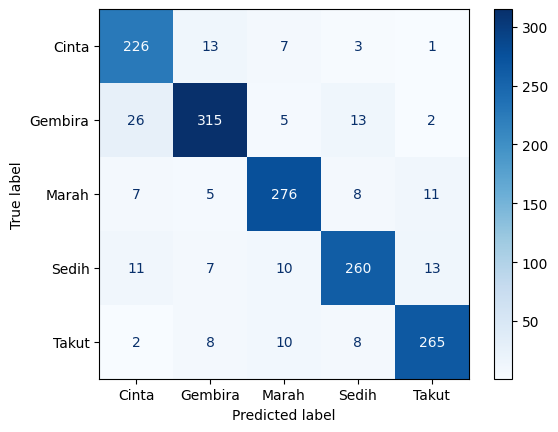

In [17]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
SAVE_DIR = "./IndoBert_Model"

os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(f'{SAVE_DIR}',save_format="tf")
tokenizer.save_pretrained(f'{SAVE_DIR}',save_format="tf")

### Inferensi Model

In [9]:
MODEL_PATH = SAVE_DIR
TOKENIZER_PATH = SAVE_DIR

In [10]:
#Load tokenizer dan model
inference_tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
inference_model = TFAutoModelForSequenceClassification.from_pretrained(SAVE_DIR)

W0000 00:00:1767770367.650509   21019 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1767770367.872013   21019 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./IndoBert_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without furt

In [11]:
EXTERNAL_TEST_PATH = "../data/external_test.csv"


# Load external dataset
external_df = pd.read_csv(EXTERNAL_TEST_PATH)

# Cek struktur dataset
print(f"External dataset shape: {external_df.shape}")
print(f"Columns: {external_df.columns.tolist()}")
print(f"\n First few rows:")
print(external_df.head())

print(f"\nClass distribution in external data:")
print(external_df['Label'].value_counts())

External dataset shape: (1932, 2)
Columns: ['Label', 'Tweet']

 First few rows:
   Label                                          Tweet
0  Cinta          rasanya mirip hati saya disusun ulang
1  Cinta      rasanya mirip saya diselimuti rasa sayang
2  Cinta  rasanya mirip hati saya ditempel spark lembut
3  Cinta           saya suka tiap dia bilang saya cukup
4  Cinta           saya suka tiap dia ngulang kata saya

Class distribution in external data:
Label
Gembira    695
Sedih      580
Marah      275
Takut      223
Cinta      159
Name: count, dtype: int64


In [12]:
# Cek label yang ada di external data
external_labels = external_df['Label'].unique()
print(f"Unique labels in external data: {external_labels}")

Unique labels in external data: ['Cinta' 'Gembira' 'Marah' 'Sedih' 'Takut']


In [13]:
le.fit(label_names)  # Fit dengan label names yang konsisten

external_df['LabelEncoded'] = le.transform(external_df['Label'])
print(f"Final external dataset: {len(external_df)} samples")

Final external dataset: 1932 samples


In [14]:
# Tokenisasi external data
external_texts = external_df['Tweet'].tolist()
external_true_labels = external_df['LabelEncoded'].tolist()

def inference_tokenize_texts(texts, max_len=MAX_LEN):
    return inference_tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

external_encodings = inference_tokenize_texts(external_texts)

# Buat dataset
external_dataset = tf.data.Dataset.from_tensor_slices((
    dict(external_encodings),
    tf.convert_to_tensor(external_true_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [15]:
# Recompile model
inference_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [16]:
# Evaluate model
external_loss, external_accuracy = inference_model.evaluate(external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {external_loss:.4f}")
print(f"External Test Accuracy: {external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")

E0000 00:00:1767770383.157145   21019 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.4892
External Test Accuracy: 0.8458
Number of samples: 1932


In [17]:
# Predictions
pred_logits = inference_model.predict(external_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)
pred_probs = tf.nn.softmax(pred_logits, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT (External Data):")
print(classification_report(
    external_true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
))


CLASSIFICATION REPORT (External Data):
              precision    recall  f1-score   support

       Cinta     0.6432    0.9182    0.7565       159
     Gembira     0.9190    0.8820    0.9001       695
       Marah     0.7396    0.9709    0.8396       275
       Sedih     0.9764    0.7138    0.8247       580
       Takut     0.7668    0.8700    0.8151       223

    accuracy                         0.8458      1932
   macro avg     0.8090    0.8710    0.8272      1932
weighted avg     0.8704    0.8458    0.8472      1932



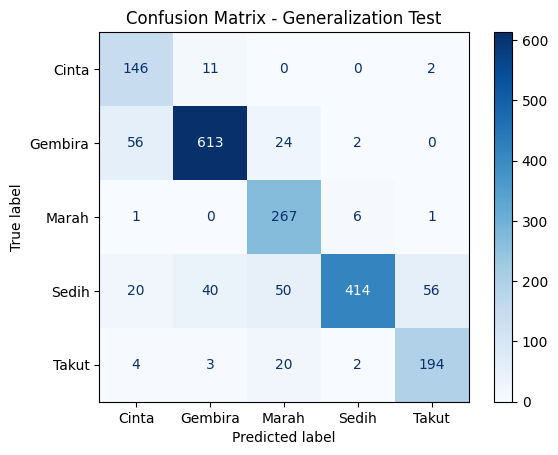

In [18]:
# Confusion Matrix
cm = confusion_matrix(external_true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(
    "Confusion Matrix - Generalization Test")
plt.show()

### Experimental with 10 Epoch

In [23]:
experiment_model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

experiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [24]:
history_final = experiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10


I0000 00:00:1767770545.676480   21781 service.cc:158] XLA service 0x75095804f0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767770545.676520   21781 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1767770545.725585   21774 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767770545.783657   21773 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1767770545.924161   21778 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


441/441 [==============================] - 94s 170ms/step - loss: 0.5090 - accuracy: 0.8293 - val_loss: 0.3960 - val_accuracy: 0.8676
Epoch 2/10
441/441 [==============================] - 69s 156ms/step - loss: 0.2285 - accuracy: 0.9253 - val_loss: 0.3928 - val_accuracy: 0.8676
Epoch 3/10
441/441 [==============================] - 67s 153ms/step - loss: 0.1409 - accuracy: 0.9521 - val_loss: 0.4194 - val_accuracy: 0.8829
Epoch 4/10
441/441 [==============================] - 67s 151ms/step - loss: 0.0850 - accuracy: 0.9732 - val_loss: 0.4733 - val_accuracy: 0.8782
Epoch 5/10
441/441 [==============================] - 65s 146ms/step - loss: 0.0566 - accuracy: 0.9820 - val_loss: 0.5088 - val_accuracy: 0.8729
Epoch 6/10
441/441 [==============================] - 66s 150ms/step - loss: 0.0499 - accuracy: 0.9838 - val_loss: 0.5574 - val_accuracy: 0.8743
Epoch 7/10
441/441 [==============================] - 64s 146ms/step - loss: 0.0353 - accuracy: 0.9904 - val_loss: 0.5804 - val_accuracy: 0.8

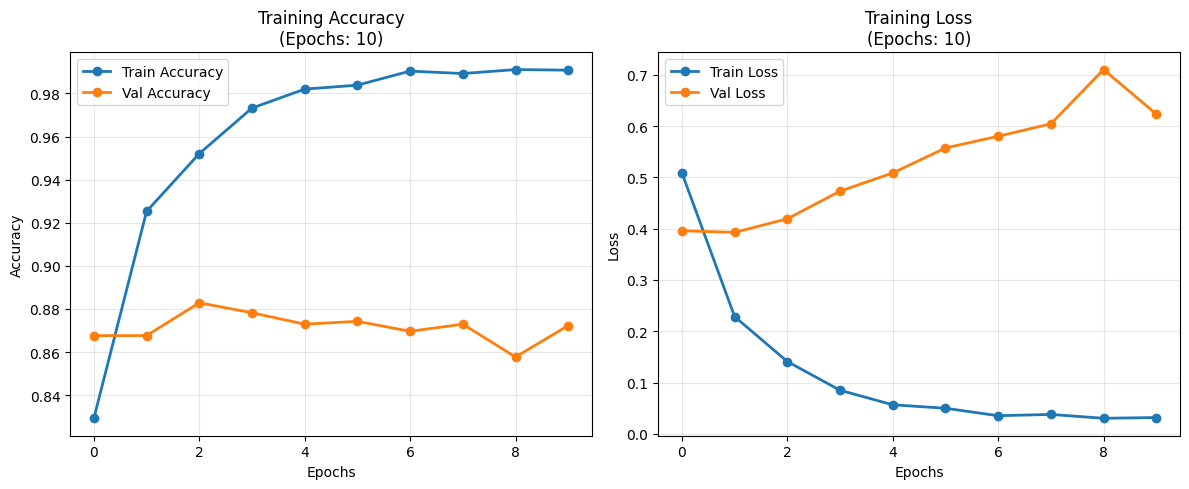

In [25]:
# Plot 4: Training History Final Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'],
         label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history_final.history['val_accuracy'],
         label='Val Accuracy', marker='o', linewidth=2)
plt.title(f'Training Accuracy\n(Epochs: 10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss',
         marker='o', linewidth=2)
plt.plot(history_final.history['val_loss'], label='Val Loss',
         marker='o', linewidth=2)
plt.title(f'Training Loss\n(Epochs: 10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
experiment_loss, experiment_accuracy = experiment_model.evaluate(test_dataset, verbose=0)
    
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {experiment_loss:.4f}")
print(f"Test Accuracy: {experiment_accuracy:.4f}")
print(f"Epochs Used: 10")


FINAL RESULTS
Test Loss: 0.6161
Test Accuracy: 0.8743
Epochs Used: 10


In [27]:
# Evaluate model
experimental_external_loss, experimental_external_accuracy = experiment_model.evaluate(
    external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {experimental_external_loss:.4f}")
print(f"External Test Accuracy: {experimental_external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.8145
External Test Accuracy: 0.8152
Number of samples: 1932
